In [173]:
#Task1
import pandas as pd; 

#combined data sets
combined_data = { 
                  'train': pd.read_csv('../Football/train.csv'), 
                  'test': pd.read_csv('../Football/test.csv') 
                }

#data preprocessing. Giving numerical values to some features
replacements = [
    {'Is_Home_or_Away': 'Home'}, {'Is_Home_or_Away': 0},
    {'Is_Home_or_Away': 'Away'}, {'Is_Home_or_Away': 1},
    {'Is_Opponent_in_AP25_Preseason': 'Out'}, {'Is_Opponent_in_AP25_Preseason': 0},
    {'Is_Opponent_in_AP25_Preseason': 'In'}, {'Is_Opponent_in_AP25_Preseason': 1},
    {'Label': 'Lose'}, {'Label': 0},
    {'Label': 'Win'}, {'Label': 1}
]

for y in combined_data:
    for x in range(0,len(replacements) - 1)[::2]:
        combined_data[y] = combined_data[y].replace(replacements[x], replacements[x+1])

#To both sets, I applied a numerical value to the Media and the Opponent feature
def apply_conversion_to_values(column, new_column):
    codes = {}
    i = 0
    grouped_series = combined_data['train'][column].append(combined_data['test'][column])
    for g, _ in grouped_series.groupby(grouped_series):
        codes[g] = i
        i = i + 1
    for x in combined_data:
        combined_data[x][new_column] = combined_data[x][column].apply(lambda y: codes[y])
    return codes

media_codes = apply_conversion_to_values('Media', 'MediaCode')
opponent_codes = apply_conversion_to_values('Opponent', 'OpponentCode')

In [174]:
#Prepare data
import numpy as np;

xTrain = combined_data['train']
xTest = combined_data['test']
yTrain = xTrain.iloc[:,6]
yTest = xTest.iloc[:,6]

for x in ['ID', 'Date', 'Opponent', 'Media', 'Label']:
    xTrain = xTrain.drop(x,1)
    xTest = xTest.drop(x,1)

xTrain = np.array(xTrain)
xTest = np.array(xTest)
yTrain = np.array(yTrain)
yTest = np.array(yTest)

KNN from scratch results (Football):
Accuracy: 0.83  with k = 7
Precision: 0.75
Recall: 0.67
F1 score: 0.7077464788732396


,ID,Label
0,25,Win
1,26,Win
2,27,Win
3,28,Win
4,29,Lose
5,30,Lose
6,31,Win
7,32,Lose
8,33,Win
9,34,Win


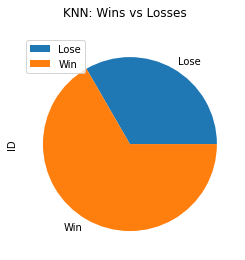

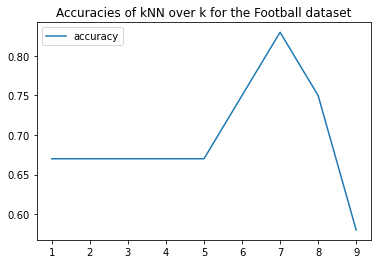

In [175]:
#KNN from Scratch
def euclidean_distances(xTrain,xTest,k):
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0) 
    distances = np.sort(distances,0) 
    return indices[0:k,:], distances[0:k,:]

def knn(xTrain,yTrain,xTest,k=3):
    indices, distances = euclidean_distances(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell = indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(max(temp,key=temp.count))
    predictions=np.array(predictions)
    return predictions

def accuracy(yTest,predictions):
    x=yTest.flatten()==predictions.flatten()
    grade=np.mean(x)
    return np.round(grade,2)

def precision(yTest, predictions):
    tp = 0
    fp = 0
    for x in range(len(predictions)):
        if predictions[x] == 1:
            if yTest[x] == 1:
                tp = tp+1
            else:
                fp = fp+1
    return np.round(tp/(tp+fp), 2)
def recall(yTest, predictions):
    tp = 0
    fn = 0
    for x in range(len(predictions)):
        if predictions[x] == 1:
            if yTest[x] == 1:
                tp = tp+1
        else:
            if yTest[x] == 1:
                fn = fn+1
    return np.round(tp/(tp+fn), 2)
def f1_score(total_recall, total_precision):
    return 2*(total_recall*total_precision)/(total_recall+total_precision)

def results_table(predictions):
    return pd.DataFrame({'ID': list(range(25, 37)), 'Label': map(lambda x: 'Win' if x == 1 else 'Lose', predictions)})

Ks = 10
mean_acc = np.zeros((Ks-1))
predictions = []
Klist = range(1,Ks)
for n in Klist:
    p = knn(xTrain,yTrain,xTest,n)
    mean_acc[n-1] = accuracy(yTest, p)
    predictions.append(p)

total_precision = precision(yTest, predictions[-1])
total_recall = recall(yTest, predictions[-1])

print('KNN from scratch results (Football):')
print('Accuracy:', np.round(mean_acc.max(),2), ' with k =', mean_acc.argmax()+1)
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

table = results_table(predictions[-1])

table.groupby('Label').count().plot(kind='pie', title='KNN: Wins vs Losses', subplots=True);

pd.DataFrame({ 'accuracy': mean_acc }, index=Klist).plot.line(title= 'Accuracies of kNN over k for the Football dataset');

table

Naïve Bayes results (Football):
Accuracy: 0.83
Precision: 1.0
Recall: 0.78
F1 score: 0.8764044943820225


,ID,Label
0,25,Win
1,26,Lose
2,27,Win
3,28,Win
4,29,Win
5,30,Lose
6,31,Lose
7,32,Win
8,33,Win
9,34,Lose


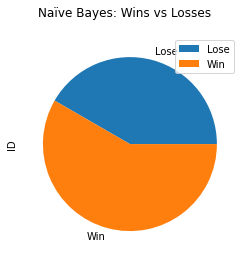

In [176]:
#Naïve Bayes sklearn
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(xTrain, yTrain)
predictions = gnb.predict(xTest)

total_precision = precision(yTest, predictions)
total_recall = recall(yTest, predictions)

print('Naïve Bayes results (Football):')
print('Accuracy:', accuracy(yTest, predictions))
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

table = results_table(predictions)

table.groupby('Label').count().plot(kind='pie', title='Naïve Bayes: Wins vs Losses', subplots=True);

table

In [177]:
#Task 2
#Q1
from sklearn.model_selection import cross_val_score; from sklearn import model_selection;

#start of data preprocess
def apply_uniform_fill(dataset, column):
    std = dataset[column].std()
    mean = dataset[column].mean()
    dataset[column] = dataset[column].apply(lambda x: np.random.uniform(mean, std, 1)[0] if np.isnan(x) else x)

def apply_conversion_to_values(column, new_column):
    codes = {}
    i = 0
    grouped_series = combined[0][column].append(combined[1][column])
    for g, _ in grouped_series.groupby(grouped_series):
        codes[g] = i
        i = i + 1
    for x in positions:
        combined[x][new_column] = combined[x][column].apply(lambda y: codes[y])
    return codes

positions = range(2)
combined = [pd.read_csv('../Titanic/train.csv'), pd.read_csv('../Titanic/test.csv')]
embarked = combined[0].pivot_table(index=['Embarked'], aggfunc ='size').to_frame().sort_values([0], ascending=False).iloc[0]
combined[0]['Embarked'] = combined[0]['Embarked'].apply(lambda x: embarked.name if pd.isnull(x) else x)
embarked_codes = apply_conversion_to_values('Embarked', 'EmbarkedCode')

for x in positions:
    for y in ['Cabin', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked']:
        combined[x] = combined[x].drop(y, 1)
    combined[x] = combined[x].replace({'Sex': 'male'}, {'Sex': 0})
    combined[x] = combined[x].replace({'Sex': 'female'}, {'Sex': 1})
    apply_uniform_fill(combined[x], 'Age')
    if(x == 1):
        apply_uniform_fill(combined[x], 'Fare')
    combined[x]['Fare'] = pd.cut(combined[x]['Fare'], bins=[-0.001,7.91,14.4542,31.0,512.3292], labels=[1,2,3,4])
    combined[x]['Age'] = pd.cut(combined[x]['Age'], bins=[0,15,25,50,75,80], labels=[1,2,3,4,5])
#end of data preprocess

yTrain = np.array(combined[0].Survived)
xTrain = np.array(combined[0].drop('Survived', 1))
xTest = np.array(combined[1])
yTest = np.array(pd.read_csv('../Titanic/gender_submission.csv').Survived)

def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1])) 

depth = []
scores_total = []
for i in range(3,20):
    clf = GaussianNB()
    scores = model_selection.cross_val_score(estimator=clf, X=xTrain, y=yTrain, cv=model_selection.KFold(n_splits=i), n_jobs=4)
    depth.append((i,scores.mean(), scores, clf))

best_split = Sort_Tuple(depth)[-1]
scores_total.append(best_split[2])
gnb = best_split[3]
gnb.fit(xTrain, yTrain)
predictions = gnb.predict(xTest)

total_precision = precision(yTest, predictions)
total_recall = recall(yTest, predictions)

print('Naïve Bayes results (Titanic):')
print('Accuracy:', accuracy(yTest, predictions))
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

Naïve Bayes results (Titanic):
Accuracy: 0.88
Precision: 0.76
Recall: 0.95
F1 score: 0.8444444444444444


KNN from scratch results (Titanic):
Accuracy: 0.87  with k = 12
Precision: 0.77
Recall: 0.72
F1 score: 0.7441610738255033


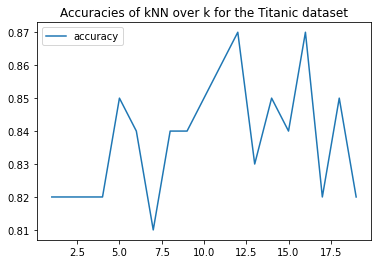

In [178]:
#KNN on titanic. Implemented a few lines above
Ks = 20
mean_acc = np.zeros((Ks-1))
predictions = []
Klist = range(1,Ks)
for n in Klist:
    p = knn(xTrain,yTrain,xTest,n)
    mean_acc[n-1] = accuracy(yTest, p)
    predictions.append(p)

total_precision = precision(yTest, predictions[-1])
total_recall = recall(yTest, predictions[-1])

print('KNN from scratch results (Titanic):')
print('Accuracy:', np.round(mean_acc.max(),2), ' with k =', mean_acc.argmax()+1)
print('Precision:', total_precision)
print('Recall:', total_recall)
print('F1 score:', f1_score(total_recall, total_precision))

pd.DataFrame({ 'accuracy': mean_acc }, index=Klist).plot.line(title= 'Accuracies of kNN over k for the Titanic dataset');